# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

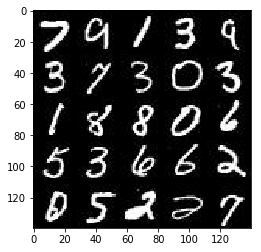

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

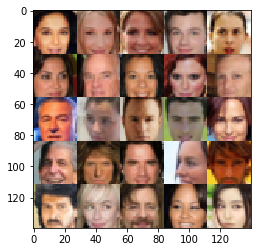

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.02
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv1 = tf.maximum(alpha * conv1, conv1)
        #14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #4x4x256
        
        #flatten 
        flat = tf.reshape(conv3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    
    
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.02
        
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #7x7x512
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        #14x14x256
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #28x28x128
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, padding='same', kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        #28x28xout_channel_dim
        
        output = tf.tanh(logits)
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_real,
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                 
    
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)
    
    l_rate = learning_rate
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                step += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                #sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) 
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                
                _ = sess.run(g_opt, feed_dict={input_z:batch_z})
                
                _ = sess.run(g_opt, feed_dict={input_z:batch_z})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z})
                
                if step % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3504... Generator Loss: 0.0595
Epoch 1/2... Discriminator Loss: 2.5024... Generator Loss: 0.1164
Epoch 1/2... Discriminator Loss: 2.4703... Generator Loss: 0.1277
Epoch 1/2... Discriminator Loss: 2.2479... Generator Loss: 0.1669
Epoch 1/2... Discriminator Loss: 2.2198... Generator Loss: 0.1619
Epoch 1/2... Discriminator Loss: 2.0405... Generator Loss: 0.2116
Epoch 1/2... Discriminator Loss: 1.9544... Generator Loss: 0.2376
Epoch 1/2... Discriminator Loss: 1.8672... Generator Loss: 0.2454
Epoch 1/2... Discriminator Loss: 1.8902... Generator Loss: 0.2284
Epoch 1/2... Discriminator Loss: 1.8422... Generator Loss: 0.2445


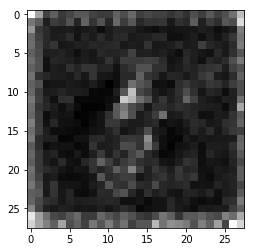

Epoch 1/2... Discriminator Loss: 1.7603... Generator Loss: 0.2697
Epoch 1/2... Discriminator Loss: 1.6678... Generator Loss: 0.3123
Epoch 1/2... Discriminator Loss: 1.7148... Generator Loss: 0.2904
Epoch 1/2... Discriminator Loss: 1.7512... Generator Loss: 0.2837
Epoch 1/2... Discriminator Loss: 1.8251... Generator Loss: 0.2418
Epoch 1/2... Discriminator Loss: 1.7872... Generator Loss: 0.2705
Epoch 1/2... Discriminator Loss: 1.6397... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 1.7519... Generator Loss: 0.2659
Epoch 1/2... Discriminator Loss: 1.8337... Generator Loss: 0.2458
Epoch 1/2... Discriminator Loss: 1.8237... Generator Loss: 0.2475


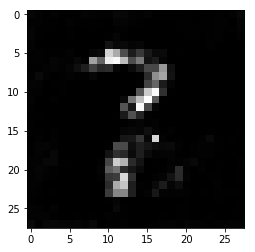

Epoch 1/2... Discriminator Loss: 1.8316... Generator Loss: 0.2433
Epoch 1/2... Discriminator Loss: 1.8105... Generator Loss: 0.2615
Epoch 1/2... Discriminator Loss: 1.8938... Generator Loss: 0.2182
Epoch 1/2... Discriminator Loss: 2.0056... Generator Loss: 0.1916
Epoch 1/2... Discriminator Loss: 1.9069... Generator Loss: 0.2244
Epoch 1/2... Discriminator Loss: 1.8942... Generator Loss: 0.2316
Epoch 1/2... Discriminator Loss: 1.8762... Generator Loss: 0.2309
Epoch 1/2... Discriminator Loss: 1.8457... Generator Loss: 0.2429
Epoch 1/2... Discriminator Loss: 1.8058... Generator Loss: 0.2676
Epoch 1/2... Discriminator Loss: 1.8275... Generator Loss: 0.2628


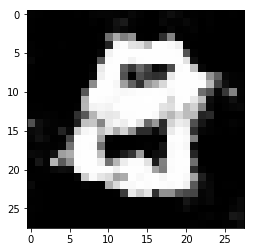

Epoch 1/2... Discriminator Loss: 1.8900... Generator Loss: 0.2348
Epoch 1/2... Discriminator Loss: 1.8590... Generator Loss: 0.2485
Epoch 1/2... Discriminator Loss: 1.8317... Generator Loss: 0.2711
Epoch 1/2... Discriminator Loss: 1.8864... Generator Loss: 0.2305
Epoch 1/2... Discriminator Loss: 1.9176... Generator Loss: 0.2454
Epoch 1/2... Discriminator Loss: 1.8287... Generator Loss: 0.2568
Epoch 1/2... Discriminator Loss: 1.7584... Generator Loss: 0.2883
Epoch 1/2... Discriminator Loss: 1.8976... Generator Loss: 0.2379
Epoch 1/2... Discriminator Loss: 1.7218... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.7212... Generator Loss: 0.3420


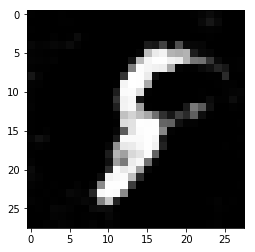

Epoch 1/2... Discriminator Loss: 1.9762... Generator Loss: 0.2035
Epoch 1/2... Discriminator Loss: 1.8527... Generator Loss: 0.2467
Epoch 1/2... Discriminator Loss: 1.7522... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 1.6302... Generator Loss: 0.5303
Epoch 1/2... Discriminator Loss: 1.7055... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.5431... Generator Loss: 0.5662
Epoch 2/2... Discriminator Loss: 1.6732... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 1.8126... Generator Loss: 0.2618
Epoch 2/2... Discriminator Loss: 1.7434... Generator Loss: 0.2805
Epoch 2/2... Discriminator Loss: 1.8921... Generator Loss: 0.2415


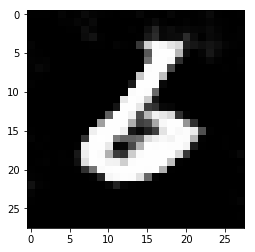

Epoch 2/2... Discriminator Loss: 1.7589... Generator Loss: 0.3084
Epoch 2/2... Discriminator Loss: 1.7582... Generator Loss: 0.2921
Epoch 2/2... Discriminator Loss: 1.7913... Generator Loss: 0.2641
Epoch 2/2... Discriminator Loss: 1.6623... Generator Loss: 0.3416
Epoch 2/2... Discriminator Loss: 1.9068... Generator Loss: 0.2273
Epoch 2/2... Discriminator Loss: 1.8034... Generator Loss: 0.2561
Epoch 2/2... Discriminator Loss: 1.6697... Generator Loss: 0.3364
Epoch 2/2... Discriminator Loss: 1.7373... Generator Loss: 0.2919
Epoch 2/2... Discriminator Loss: 1.8760... Generator Loss: 0.2323
Epoch 2/2... Discriminator Loss: 1.7525... Generator Loss: 0.2903


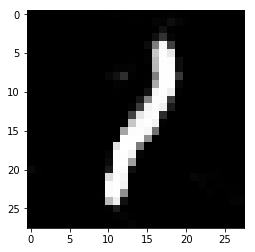

Epoch 2/2... Discriminator Loss: 1.8178... Generator Loss: 0.2523
Epoch 2/2... Discriminator Loss: 1.7275... Generator Loss: 0.3153
Epoch 2/2... Discriminator Loss: 1.8350... Generator Loss: 0.2647
Epoch 2/2... Discriminator Loss: 1.7308... Generator Loss: 0.3088
Epoch 2/2... Discriminator Loss: 1.8745... Generator Loss: 0.2312
Epoch 2/2... Discriminator Loss: 1.6258... Generator Loss: 0.3510
Epoch 2/2... Discriminator Loss: 1.9522... Generator Loss: 0.2076
Epoch 2/2... Discriminator Loss: 1.7891... Generator Loss: 0.2862
Epoch 2/2... Discriminator Loss: 1.5724... Generator Loss: 0.3962
Epoch 2/2... Discriminator Loss: 1.6275... Generator Loss: 0.5013


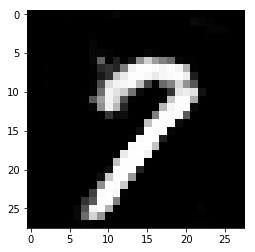

Epoch 2/2... Discriminator Loss: 1.6455... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 1.6584... Generator Loss: 0.4557
Epoch 2/2... Discriminator Loss: 1.7195... Generator Loss: 0.6068
Epoch 2/2... Discriminator Loss: 1.6024... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.6726... Generator Loss: 0.3921
Epoch 2/2... Discriminator Loss: 1.7401... Generator Loss: 0.4931
Epoch 2/2... Discriminator Loss: 1.7085... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.6159... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 1.7025... Generator Loss: 0.5847


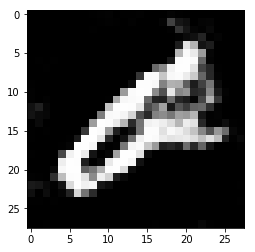

Epoch 2/2... Discriminator Loss: 1.6671... Generator Loss: 0.4638
Epoch 2/2... Discriminator Loss: 1.6809... Generator Loss: 0.4011
Epoch 2/2... Discriminator Loss: 1.6961... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 1.7008... Generator Loss: 0.4791
Epoch 2/2... Discriminator Loss: 1.6363... Generator Loss: 0.4977
Epoch 2/2... Discriminator Loss: 1.6806... Generator Loss: 0.5318
Epoch 2/2... Discriminator Loss: 1.5833... Generator Loss: 0.6407
Epoch 2/2... Discriminator Loss: 1.6176... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 1.5907... Generator Loss: 0.5753
Epoch 2/2... Discriminator Loss: 1.6254... Generator Loss: 0.6832


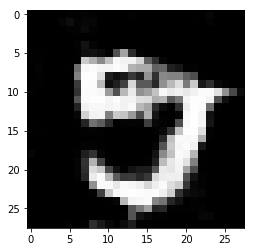

Epoch 2/2... Discriminator Loss: 1.7041... Generator Loss: 0.3347
Epoch 2/2... Discriminator Loss: 1.9896... Generator Loss: 0.2020
Epoch 2/2... Discriminator Loss: 1.8091... Generator Loss: 0.2713


In [40]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.3978... Generator Loss: 0.0150
Epoch 1/1... Discriminator Loss: 3.6058... Generator Loss: 0.0355
Epoch 1/1... Discriminator Loss: 2.9480... Generator Loss: 0.0716
Epoch 1/1... Discriminator Loss: 2.8641... Generator Loss: 0.0854
Epoch 1/1... Discriminator Loss: 2.7936... Generator Loss: 0.0854
Epoch 1/1... Discriminator Loss: 2.5870... Generator Loss: 0.1088
Epoch 1/1... Discriminator Loss: 2.3527... Generator Loss: 0.1849
Epoch 1/1... Discriminator Loss: 2.2914... Generator Loss: 0.1497
Epoch 1/1... Discriminator Loss: 2.3168... Generator Loss: 0.1630
Epoch 1/1... Discriminator Loss: 1.6988... Generator Loss: 0.7409


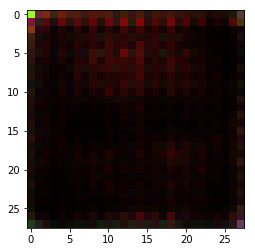

Epoch 1/1... Discriminator Loss: 1.7682... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.6660... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 2.1326... Generator Loss: 0.2030
Epoch 1/1... Discriminator Loss: 2.0127... Generator Loss: 0.2355
Epoch 1/1... Discriminator Loss: 1.9764... Generator Loss: 0.2268
Epoch 1/1... Discriminator Loss: 2.3353... Generator Loss: 0.1379
Epoch 1/1... Discriminator Loss: 2.1907... Generator Loss: 0.1777
Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.9215... Generator Loss: 0.2476
Epoch 1/1... Discriminator Loss: 1.7765... Generator Loss: 0.3444


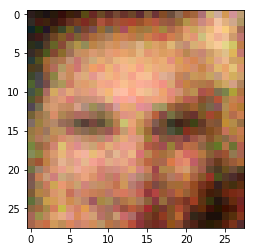

Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.6375... Generator Loss: 0.4413


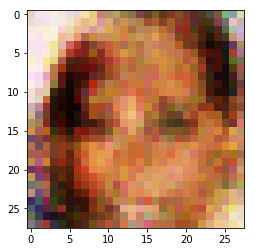

Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 1.8071... Generator Loss: 0.2942
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7423


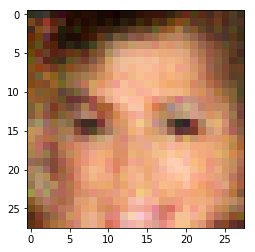

Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 0.3788
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.5553


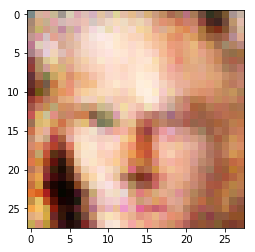

Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.6064


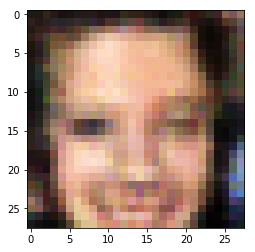

Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.5694


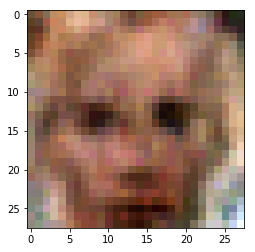

Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6641


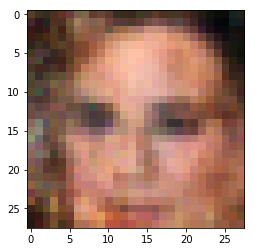

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.5688


KeyboardInterrupt: 

In [41]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.